In [ ]:
%pip install pydub librosa matplotlib "numpy<2" "tensorflow<2.11.0" "tensorflow-gpu<2.11.0"

In [6]:
import os
from pydub import AudioSegment

# 디렉토리 설정
input_dir = './m4a'
output_dir = './wav'

# 출력 디렉토리 생성 (존재하지 않으면)
os.makedirs(output_dir, exist_ok=True)

# m4a 파일 리스트
files = [f for f in os.listdir(input_dir) if f.endswith('.m4a')]

for file in files:
    # 파일 경로 설정
    m4a_path = os.path.join(input_dir, file)
    wav_path = os.path.join(output_dir, file.replace('.m4a', '.wav'))

    # m4a -> wav 변환
    sound = AudioSegment.from_file(m4a_path, format="m4a")
    sound.export(wav_path, format="wav")

In [13]:
import numpy as np
import librosa

# RMS 추출 함수
def extract_rms_from_file(file_path, frame_length=2048, hop_length=512):
    y, sr = librosa.load(file_path, sr=None)
    rms = librosa.feature.rms(y=y, frame_length=frame_length, hop_length=hop_length)[0]
    return rms, sr

# 시퀀스 생성 함수
def create_sequences(data, window_size, stride=10):
    X, y = [], []
    for i in range(0, len(data) - window_size, stride):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

In [16]:
# 경로 및 파라미터 설정
wav_dir = './wav'
window_size = 20

# 전체 데이터 수집
X_all, y_all = [], []

for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        try:
            rms, sr = extract_rms_from_file(file_path)
            if rms is None:  # rms가 None일 경우 건너뛰기
                continue
            X, y = create_sequences(rms, window_size)
            if len(X) > 0 and len(y) > 0:  # X, y가 비어있지 않다면
                X_all.append(X)
                y_all.append(y)
        except Exception as e:
            print(f"Failed to process {filename}: {e}")

# X_all과 y_all이 비어있지 않은지 확인
if len(X_all) == 0 or len(y_all) == 0:
    print("No data to process.")
else:
    # 하나의 큰 배열로 합치기
    X_total = np.concatenate(X_all, axis=0)
    y_total = np.concatenate(y_all, axis=0)

    # LSTM 입력 형식으로 변형
    X_total = X_total.reshape((X_total.shape[0], X_total.shape[1], 1))

    print(f'총 시퀀스 개수: {X_total.shape[0]}, 입력 shape: {X_total.shape}')
    print(f'총 레이블 개수: {y_total.shape[0]}, 레이블 shape: {y_total.shape}')

총 시퀀스 개수: 82178, 입력 shape: (82178, 20, 1)
총 레이블 개수: 82178, 레이블 shape: (82178,)


Epoch 1/50
2055/2055 [==============================] - 16s 7ms/step - loss: 5.3833e-05 - val_loss: 1.9423e-05
Epoch 2/50
2055/2055 [==============================] - 14s 7ms/step - loss: 1.8786e-05 - val_loss: 1.7254e-05
Epoch 3/50
2055/2055 [==============================] - 15s 7ms/step - loss: 1.7963e-05 - val_loss: 1.8235e-05
Epoch 4/50
2055/2055 [==============================] - 14s 7ms/step - loss: 1.7236e-05 - val_loss: 1.5685e-05
Epoch 5/50
2055/2055 [==============================] - 14s 7ms/step - loss: 1.6207e-05 - val_loss: 1.5558e-05
Epoch 6/50
2055/2055 [==============================] - 13s 6ms/step - loss: 1.5882e-05 - val_loss: 1.5942e-05
Epoch 7/50
2055/2055 [==============================] - 14s 7ms/step - loss: 1.5927e-05 - val_loss: 1.5822e-05
Epoch 8/50
2055/2055 [==============================] - 13s 6ms/step - loss: 1.5839e-05 - val_loss: 1.7146e-05
Epoch 9/50
2055/2055 [==============================] - 13s 6ms/step - loss: 1.5651e-05 - val_loss: 1.5489e-05
E

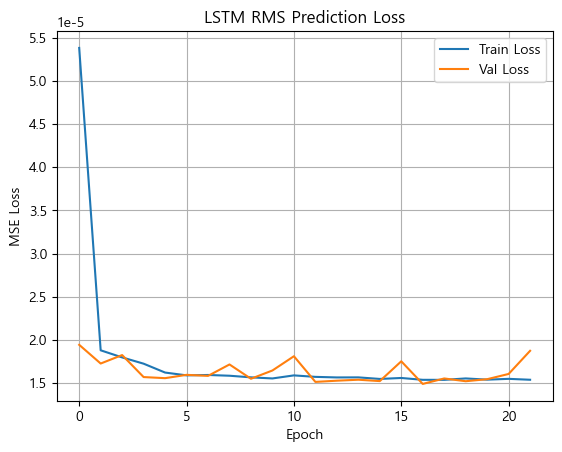

In [17]:
from tensorflow.keras.models import Sequential # type: ignore
from tensorflow.keras.layers import LSTM, Dense # type: ignore
from tensorflow.keras.callbacks import EarlyStopping # type: ignore
import matplotlib.pyplot as plt

# LSTM 모델 정의
model = Sequential([
    LSTM(64, input_shape=(X_total.shape[1], 1)),
    Dense(1)  # 다음 시점의 RMS 값을 예측
])

model.compile(optimizer='adam', loss='mse')

# 조기 종료 콜백
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# 모델 학습
history = model.fit(
    X_total, y_total,
    epochs=50,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop]
)

# 모델 저장
model.save('lstm_rms_model.h5')

# 학습 손실 시각화
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('LSTM RMS Prediction Loss')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
import os
import numpy as np
import matplotlib.pyplot as plt
import librosa
from tensorflow.keras.models import load_model  # type: ignore

# 한글 폰트 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False

# 디렉토리 설정
wav_dir = './wav'
prediction_dir = './prediction'
os.makedirs(prediction_dir, exist_ok=True)

# 하이퍼파라미터
window_size = 20
stride = 10
frame_length = 2048
hop_length = 512

# 모델 불러오기
model = load_model('lstm_rms_model.h5')

# 예측 및 시각화
for filename in os.listdir(wav_dir):
    if filename.endswith('.wav'):
        file_path = os.path.join(wav_dir, filename)
        try:
            rms, sr = extract_rms_from_file(file_path, frame_length, hop_length)

            # 시간 벡터 생성
            frames = np.arange(len(rms))
            times = librosa.frames_to_time(frames, sr=sr, hop_length=hop_length)

            # 시퀀스 생성
            X, y_true = create_sequences(rms, window_size, stride=stride)
            X = X.reshape((X.shape[0], X.shape[1], 1))

            # 예측
            y_pred = model.predict(X).flatten()

            # 예측용 x축 (시간 단위)
            pred_times = times[window_size::stride][:len(y_pred)]

            # 시각화
            plt.figure(figsize=(10, 6))
            plt.plot(times, rms, label='Original RMS')
            plt.plot(pred_times, y_pred, label='Predicted RMS', color='orange')
            plt.title(f'{filename} - RMS Prediction')
            plt.xlabel('Time (s)')
            plt.ylabel('RMS')
            plt.legend()
            plt.grid(True)

            # 저장
            prediction_file_path = os.path.join(prediction_dir, f'{os.path.splitext(filename)[0]}_prediction.png')
            plt.savefig(prediction_file_path)
            plt.close()

        except Exception as e:
            print(f"Failed to process {filename}: {e}")


17/17 [==============================] - 0s 2ms/step
